In [30]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import math
import random

In [2]:
!wget "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
!unzip ml-100k.zip
!ls

--2021-05-29 08:34:04--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.71MB/s    in 0.8s    

2021-05-29 08:34:05 (5.71 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [3]:
data = pd.read_csv("ml-100k/u1.base", sep='\t',names="userId,movieId,rating,timestamp".split(",")) 
u1_data = data.copy()
u1_data

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [4]:
user_list = u1_data['userId']
user_list = user_list.unique()
test_novelty = pd.DataFrame(user_list, columns = ["userId"])

movie_rated_by_user = u1_data.groupby('movieId')['userId'].count().reset_index(name='userIdCount')
movie_rated_by_user = movie_rated_by_user.set_index('movieId')
index_list = movie_rated_by_user.index.tolist()

def find_missing(lst):
    max_num = max(lst)
    min_num = min(lst)
    num_range = range(min_num, max_num+1)
    missing_number = list(set(num_range) - set(lst))
     
    return missing_number

what = find_missing(index_list)
for i in what:
  movie_rated_by_user.loc[i] = [1]
movie_rated_by_user.sort_index()

,userIdCount
movieId,
1,383
2,105
3,75
4,171
5,69
...,...
1678,1
1679,1
1680,1


In [5]:
user_ids = u1_data["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
print('This is user-to-encodeduser')
print(list(user2user_encoded.items())[:10])

userencoded2user = {i: x for i, x in enumerate(user_ids)}
print('This is encodeduser-to-user')
print(list(userencoded2user.items())[:10])

This is user-to-encodeduser
[(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9)]
This is encodeduser-to-user
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]


In [6]:
movie_ids = np.arange(1, 1683)
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
print('This is encodedmovie-to-movie')
print(list(movie2movie_encoded.items())[:10])

movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
print('This is movie-to-encodedmovie')
print(list(movie_encoded2movie.items())[:10])

This is encodedmovie-to-movie
[(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9)]
This is movie-to-encodedmovie
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]


In [7]:
u1_data["user"] = u1_data["userId"].map(user2user_encoded)
u1_data["movie"] = u1_data["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
u1_data["rating"] = u1_data["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later

min_rating = min(u1_data["rating"])
max_rating = max(u1_data["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 943, Number of Movies: 1682, Min rating: 1.0, Max rating: 5.0


In [8]:
x = u1_data[["user", "movie"]].values
x

array([[   0,    0],
       [   0,    1],
       [   0,    2],
       ...,
       [ 942, 1187],
       [ 942, 1227],
       [ 942, 1329]])

In [9]:
# Normalize the targets between 0 and 1. Makes it easy to train.
y = u1_data["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y

array([1.  , 0.5 , 0.75, ..., 0.5 , 0.5 , 0.5 ])

In [10]:
test = pd.read_csv("ml-100k/u1.test", sep='\t',names="userId,movieId,rating,timestamp".split(","))
test

,userId,movieId,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


In [11]:
test["user"] = test["userId"].map(user2user_encoded)
test["movie"] = test["movieId"].map(movie2movie_encoded)
test

,userId,movieId,rating,timestamp,user,movie
0,1,6,5,887431973,0,5
1,1,10,3,875693118,0,9
2,1,12,5,878542960,0,11
3,1,14,5,874965706,0,13
4,1,17,3,875073198,0,16
...,...,...,...,...,...,...
19995,458,648,4,886395899,457,647
19996,458,1101,4,886397931,457,1100
19997,459,934,3,879563639,458,933
19998,460,10,3,882912371,459,9


In [12]:
# Filter out the rating below 3 as we consider high rated items are those rating equal or above 3
indexNames = test[test['rating'] < 3 ].index
 
# Delete these row indexes from dataFrame
high_test = test.copy().drop(indexNames)
test_precision = high_test.copy().groupby('userId')['movieId'].agg(actual = lambda x: list(set(x)))
test_precision

,actual
userId,
1,"[6, 10, 12, 14, 17, 20, 23, 24, 31, 33, 39, 44..."
2,"[257, 13, 19, 279, 280, 281, 290, 292, 297, 29..."
3,"[350, 354, 327, 328, 299, 331, 334, 307, 343, ..."
4,"[288, 354, 260, 356, 294, 357, 264, 361, 303, 50]"
5,"[384, 1, 2, 385, 391, 139, 267, 143, 144, 17, ..."
...,...
457,"[192, 704, 708, 775, 366, 182, 443, 636]"
458,"[144, 1101, 648]"
459,[934]


In [13]:
x_test = test[["user", "movie"]].values
y_test = test["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [14]:
x_train = x
x_val =  x_test
y_train =  y
y_val = y_test

In [15]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
1250/1250 [==============================] - 6s 3ms/step - loss: 0.6537 - val_loss: 0.6419
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6306 - val_loss: 0.6328
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6224 - val_loss: 0.6268
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6188 - val_loss: 0.6254
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6184 - val_loss: 0.6209
Epoch 6/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6173 - val_loss: 0.6219
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6172 - val_loss: 0.6235
Epoch 8/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6167 - val_loss: 0.6233
Epoch 9/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6179 - val_loss: 0.6212
Epoch 10/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.617

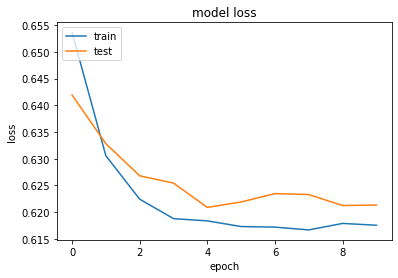

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [18]:
item_column_name = "movieId,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western"
item = pd.read_csv("ml-100k/u.item",sep='|',names=item_column_name.split(","),encoding='latin-1')
item['movieId'] = item['movieId'].map(movie2movie_encoded)
col_to_removed = ['movie_title', 'release_date', 'video_release_date', 'IMDb_URL']
clear_item = item.drop(col_to_removed, axis=1).set_index('movieId')

# the number of the kinds of topics in the whole recommendation system.
N = len(clear_item.columns)

# sum up the genre for each movieId
genre_num = clear_item.sum(axis = 1)

# group table by index and creates a dict with lists of clear_item as values
df_dict = dict(list(clear_item.groupby(clear_item.index)))

# Gather all the genres that related to all movies respectively
movieid = []
genre_list = []

for u, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    if len(check) > 0:
      movieid.append(u)
      genre_list.append(check.to_list())

d = {'movieId' : movieid, 'Genres' : genre_list}

# compile in DataFrame
genre_list_by_movieid = pd.DataFrame(d)
genre_list_by_movieid.set_index('movieId', inplace=True)
genre_list_by_movieid

,Genres
movieId,
0,"[Animation, Children, Comedy]"
1,"[Action, Adventure, Thriller]"
2,[Thriller]
3,"[Action, Comedy, Drama]"
4,"[Crime, Drama, Thriller]"
...,...
1677,[Drama]
1678,"[Romance, Thriller]"
1679,"[Drama, Romance]"


In [19]:
item

,movieId,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
def get_recommendation(user_id, n):
  movies_watched_by_user = u1_data[u1_data.userId == user_id]
  movies_not_watched = item[~item["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
  movieslist_not_watched = list(
      set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
  )

  movies_not_watched = [[movie2movie_encoded.get(x)] for x in movieslist_not_watched]
  user_encoder = user2user_encoded.get(user_id)
  user_movie_array = np.hstack(
      ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
  )
  ratings = model.predict(user_movie_array).flatten()
  top_ratings_indices = ratings.argsort()[-n:][::-1]
  recommended_movie_ids = [
      movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
  ]

  recommended_movies = item[item["movieId"].isin(recommended_movie_ids)].movieId
  
  return recommended_movies.tolist()

In [28]:
"""
Precision computation
"""

def precision_per_user(user):
  # get the actual data
  check_a = test_precision.loc[user]
  # check intersect item
  result = float(len(np.intersect1d(check_a['actual'],check_a['predictions'])))

  # user set in test set
  U = 1.00
  # length of recommendation list
  L = min(len(check_a['actual']), len(check_a['predictions']))

  
  precision = (1.0 / U) * (result/L)

  return precision

"""
Novelty computation
"""

def novelty_per_user(user):

  M = num_users
  L = 10
  sum_novelty = 0
  movie_list = test_precision['predictions'].loc[user]
  for u in movie_list:
    rate_number = movie_rated_by_user.loc[u]
    if (int(rate_number) == 0):
      sum_novelty += 0
    else:
      sum_novelty += math.log2(M/rate_number)

  novelty = sum_novelty/len(movie_list)
  return novelty

"""
Diversity computation
"""

# this function is to check how many genre (topics) included in the movie item
def check_genre_num(movieid):
  n_genre = genre_num.loc[movieid]
  return n_genre

# this function is to get the list of genre that included in the movieId
def check_genre_list(movieid):
  movie_genres = genre_list_by_movieid['Genres'].loc[movieid]
  return movie_genres

# get the movie list per user and return the total genres for that list, z_Lu
def total_genre_per_list(user_movies_list):
  
  total_num_list = []
  
  for n in user_movies_list:
      genre = check_genre_list(n)
      for g in genre:
        total_num_list.append(g)
  
  return total_num_list, len(total_num_list)

# get the movie list per user and return the unique genres for that list, S_Lu
def get_unique_genre_list_by_user(user_movies_list):

  total_list = []
  
  for h in user_movies_list:
    g = check_genre_list(h)
    for k in g:
      total_list.append(k)
  
  unique_list = list(set(total_list))

  return unique_list, len(unique_list)

def H_lu(lu):
  slu, n_slu = get_unique_genre_list_by_user(lu)
  zlu, n_zlu = total_genre_per_list(lu)
  H_lu = 0
  # need to find how many times that topic j is appear in Z_Lu list
  for j in slu:
    count_appear = zlu.count(j)
    qj = count_appear/n_zlu
    H_lu += qj * math.log2(qj)

  return -H_lu

def Div_lu(Lu):
  sl , SLu = get_unique_genre_list_by_user(Lu)
  Nt = N
  hlu = H_lu(Lu)
  Div_lu = (SLu / Nt) * hlu

  return Div_lu

# get the userId list in prediction result
def diversity_per_user(user):
  value1 = 0
  dot_part = 0
  movie_list = test_precision['predictions'].loc[user]

  # total number of topics in recommendation list per user
  zlu, n_zlu = total_genre_per_list(movie_list)

  for item in movie_list:
    txi = check_genre_num(item)
    value1 = txi/n_zlu
    value2 = math.log2(txi/n_zlu)
    dot_part += np.dot(value1,value2)
  diversity_lu = -(dot_part) * Div_lu(movie_list)

  return diversity_lu

def d2(user):
  value1 = 0
  dot_part = 0
  movie_list = test_precision['predictions'].loc[user]

  # total number of topics in recommendation list per user
  zlu, n_zlu = total_genre_per_list(movie_list)

  for item in movie_list:
    txi = check_genre_num(item)
    value1 = txi/n_zlu
    value2 = math.log10(txi/n_zlu)
    dot_part += np.dot(value1,value2)
  diversity2 = -(dot_part) * Div_lu(movie_list)

  return diversity2

In [31]:
import time
start_time = time.time()

all_avg_precision = []
all_avg_novelty = []
all_avg_diversity = []

recs = []

print('Prediction start....')
pred_start_time = time.time()

for i in test_precision.index:

  predictions = get_recommendation(i, 10) #len(test_precision.actual.loc[user])
  recs.append(predictions)

execute_duration = time.time() - pred_start_time
print('Done prediction for all users....')
print("\n--- %s seconds ---" % execute_duration)
print()
print('Average duration for each user....')
print("\n--- %s seconds ---" % (execute_duration/943))
print()

test_precision['predictions'] = recs
loss = []
precision = []
novelty = []
diversity = []
diversity2 = []

for ul in test_precision.index:
  precision.append(precision_per_user(ul))

  novelty.append(novelty_per_user(ul))

  diversity.append(diversity_per_user(ul))
  diversity2.append(d2(ul))


print("---------Precision-------")
print("Precision max: ", max(precision))
print("Precision min: ", min(precision))
print("Precision mean: ", np.mean(precision))
print()

print("---------Novelty-------")
print("Novelty max: ", max(novelty))
print("Novelty min: ", min(novelty))
print("Novelty mean: ", np.mean(novelty))
print()

print("---------Diversity-------")
print("Diversity max: ", max(diversity))
print("Diversity min: ", min(diversity))
print("Diversity mean: ", np.mean(diversity))
print()

print("---------D2-------")
print("Diversity max: ", max(diversity2))
print("Diversity min: ", min(diversity2))
print("Diversity mean: ", np.mean(diversity2))

Prediction start....
Done prediction for all users....

--- 50.15366744995117 seconds ---

Average duration for each user....

--- 0.0531852252915707 seconds ---

---------Precision-------
Precision max:  0.9
Precision min:  0.0
Precision mean:  0.1419173842376457

---------Novelty-------
Novelty max:  4.4734909771082885
Novelty min:  2.028403278318664
Novelty mean:  2.589132389407694

---------Diversity-------
Diversity max:  9.284372030280691
Diversity min:  1.1121520910738796
Diversity mean:  4.984018841389775

---------D2-------
Diversity max:  2.794874472018185
Diversity min:  0.3347911391536576
Diversity mean:  1.5003391702127644


In [32]:
column = {'Precision':precision, 'Novelty':novelty, 'Diversity': diversity,'D2': diversity2}
table = pd.DataFrame(column)
table[:10]

,Precision,Novelty,Diversity,D2
0,0.4,2.488833,5.726510,1.723851
1,0.0,2.447150,4.665975,1.404598
2,0.1,2.242151,3.971893,1.195659
3,0.1,2.887858,3.361341,1.011864
4,0.0,2.393096,6.800054,2.047020
5,0.6,2.611608,7.637324,2.299064
6,0.6,2.738979,4.937897,1.486455
7,0.1,2.500921,4.299880,1.294393
8,0.0,2.430236,2.888474,0.869517
9,0.3,2.675519,3.473430,1.045607


In [33]:
print(table.loc[table['Precision'].idxmax()])
print(table.loc[table['Novelty'].idxmax()])
print(table.loc[table['Diversity'].idxmax()])

Precision    0.900000
Novelty      2.028403
Diversity    6.137518
D2           1.847577
Name: 307, dtype: float64
Precision    0.000000
Novelty      4.473491
Diversity    4.922400
D2           1.481790
Name: 334, dtype: float64
Precision    0.000000
Novelty      2.200463
Diversity    9.284372
D2           2.794874
Name: 46, dtype: float64
